## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb

* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice.

    Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Run only if necessary :)
!pip install simpletransformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
  Cre

In [4]:
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space']

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

# roBERTa

In [5]:
# Start Coding here

# Naive Bayes with Bag of Words

In [6]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})

print("Train Data Distribution:")
print(train['labels'].value_counts())
print("\nTest Data Distribution:")
print(test['labels'].value_counts())

Train Data Distribution:
labels
2    594
3    593
1    584
0    480
Name: count, dtype: int64

Test Data Distribution:
labels
2    396
3    394
1    389
0    319
Name: count, dtype: int64


In [7]:
train, dev = train_test_split(train, test_size=0.1, random_state=0, stratify=train[['labels']])

In [8]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train['text'])
X_dev = vectorizer.transform(dev['text'])
X_test = vectorizer.transform(test['text'])

### Training The Model

In [9]:
nb_model = MultinomialNB()
nb_model.fit(X_train, train['labels'])

MultinomialNB()

### Eval. Dev Set

In [10]:
y_dev_pred = nb_model.predict(X_dev)
print("Validation Classification Report:")
print(classification_report(dev['labels'], y_dev_pred))

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        48
           1       0.92      0.95      0.93        59
           2       0.95      0.90      0.92        60
           3       0.91      0.73      0.81        59

    accuracy                           0.88       226
   macro avg       0.88      0.88      0.87       226
weighted avg       0.89      0.88      0.88       226



### Eval. Test Set

In [11]:
y_test_pred = nb_model.predict(X_test)
test['predicted'] = y_test_pred
print("Test Classification Report:")
print(classification_report(test['labels'], test['predicted']))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       319
           1       0.92      0.87      0.89       389
           2       0.83      0.87      0.85       396
           3       0.90      0.78      0.83       394

    accuracy                           0.85      1498
   macro avg       0.85      0.85      0.85      1498
weighted avg       0.86      0.85      0.85      1498



# Comparisons

### BERT vs. roBERTa

Comparing BERT and roBERTa by looking at their performances by taking BERT's performance from Lab6.4 (screenshot of the losses provided below together with evaluation metrics), we can see that the accuracy for both is exactly the same - 0.86. Looking more closely, there is segregation between class 0 and 3 - class 0 and 3 has higher precision when roBERTa is used than BERT. Similarly, class 1 and 2 have higher recall when roBERTa is used, and the vice versa goes for BERT. Regardng f1 score, for each class it is either the same or differs by only 0.01.

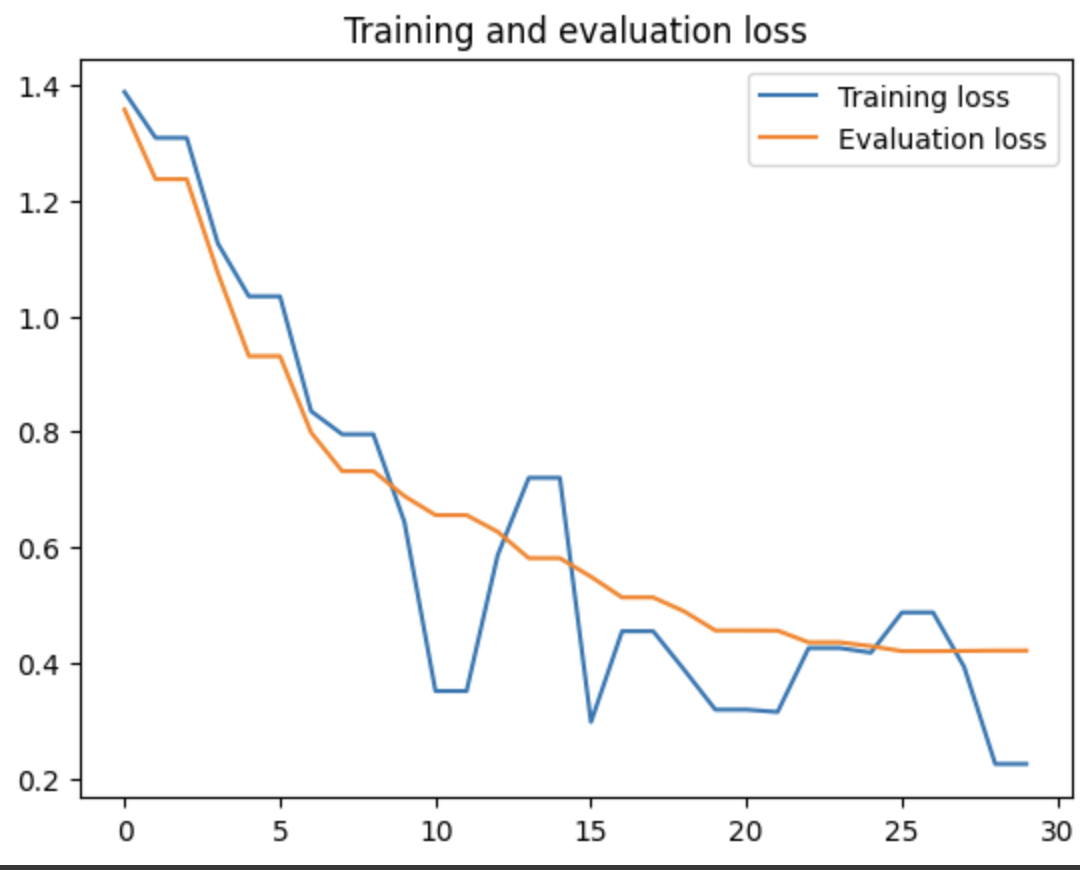

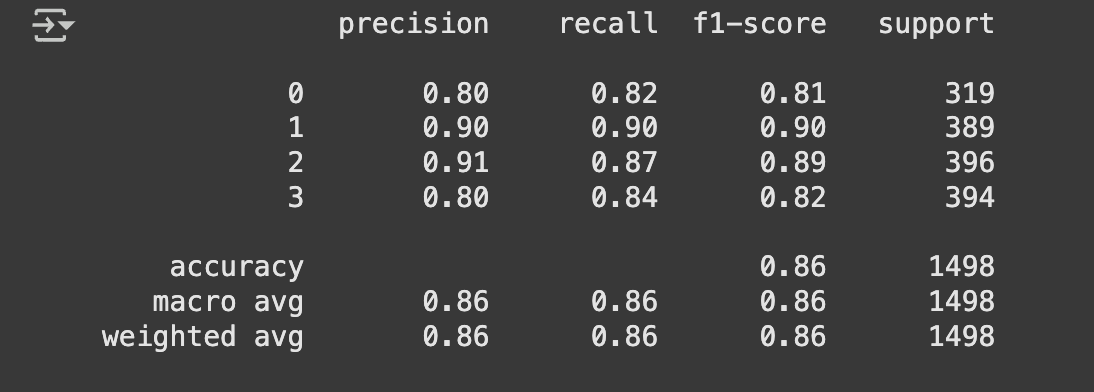

### BERT vs. Naive Bayes w/ Bag of Words (BoW)

Comparing BERT and Naive Bayes with Bag of Words by looking at the BERT's performance from Lab6.4 (screenshot of the evaluation provided below), we can see that BERT's accuracy is slightly, but only slightly better than Naive Bayes with 0.86 and 0.85 respectively. BERT also has better precision in class 0 and 2, while the Naive Bayes have better precision in class 1 and 3. From this perspective, we can call it a tie. Moving on to the recall, class 2 have same recall for both, recall in class 0 is higher with Bayes, but recall for class 3 is higher with BERT. Lastly, f1 score brings is to a tie as well, since for 2 classes Naive Bayes has higher scores (class 0 and 2), when for other 2 classes (class 1 and 3) of Naive Bayes with BoW has higher numbers for f1-score. This tells us that the performance difference between BERT and Naive Bayes with Bag of words is minimal.

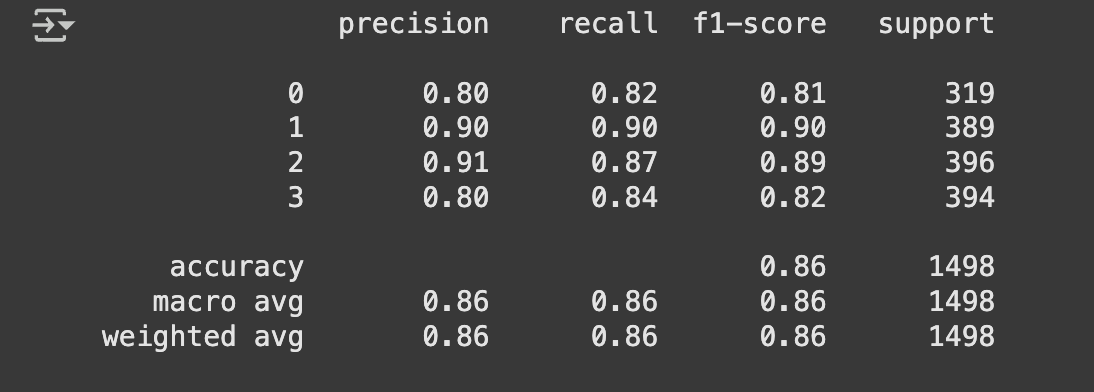